In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [4]:
# Especificar una seed para reproducibilidad de resultados
def set_seed(seed) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 56
set_seed(seed)

# Dataset

Para este ejercicio he elegido el dataset Beijing PM2.5.

Este Dataset recoge datos de la contaminacion de del aire en Pekin en el periodo del 1/1/2010 al 31/12/2014. Las features disponibles son:
 - ano, mes, dia y hora
 - DEWP: Rocio
 - TEMP: Temperatura
 - PRES: Presion
 - cbwd: Direccion del viento acumulada
 - lws: Velocidad del viento acumulada
 - Is: Horas de nieve acumuladas
 - Ir: horas de lluvia acumuladas

La variable de regresion es 'pm2.5', de la cual no tenemos los datos completos. Se refiere a la concentracion de pm2.5 (particulas de conatminacion menores a 2.5 micrometros de diametro).

In [5]:
# Cargamos el dataset de la pagina web oficial y lo guardamos en un DataFrame
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
original_data = pd.read_csv(url)

In [6]:
# En primer lugar descartamos los estados que no tengan un valor de PM2.5.
data = original_data.dropna(subset=['pm2.5']).copy()

# Hare un encoding de la direccion del viento usando el angulo (siendo el norte 0 grados)
val, counts = np.unique(data['cbwd'], return_counts=True)
data['cbwd'] = data['cbwd'].map({'cv': 0, 'NW': 315, 'NE': 45, 'SE': 135})
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,135,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,135,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,135,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,135,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,135,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,315,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,315,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,315,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,315,246.72,0,0


In [7]:
# Normalizamos el dataset y guardamos las columnas en una variable 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
columns = data.columns


In [8]:
# Definimos el Dataset que usaremos para entrenar el modelo. 
# Este Dataset se encargara de generar las secuencias de datos que se usaran para entrenar el modelo.
class TimeSeriesDataset(Dataset):
    def __init__(self, 
                 data: np.array,
                 n_steps: int,
                 target_column: int):
        
        self.data = data
        self.n_steps = n_steps
        self.target_column = target_column
        self.feature_columns = [i for i in range(data.shape[1]) if i != target_column]
    
    def __len__(self):
        return len(self.data) - self.n_steps

    def __getitem__(self, index):
        x = self.data[index:index + self.n_steps, self.feature_columns]
        y = self.data[index + self.n_steps, self.target_column]
        return torch.FloatTensor(x), torch.FloatTensor([y])

In [9]:
n_steps = 48  # Horas previas utiliazadas para la prediccion
dataset = TimeSeriesDataset(scaled_data, n_steps=n_steps, target_column=columns.get_loc('pm2.5'))

In [10]:
# Definimos el tamaño de los conjuntos de train y test (100 horas).
train_size = scaled_data.shape[0]-100
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Datasets
train_dataset = TimeSeriesDataset(train_data, n_steps=n_steps, target_column=columns.get_loc('pm2.5'))
test_dataset = TimeSeriesDataset(test_data, n_steps=n_steps, target_column=columns.get_loc('pm2.5'))

train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
# DataLoader
batch_size = 2048
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definicion del Modelo Base

Definimos un modelo base basado en pytorch lightning. Esto me ahorrara tener que definir los diferentes metodos necesarios en el resto de modelos que testeare

In [11]:
class BaseModel(pl.LightningModule):
    def __init__(
        self,
        loss_fn: torch.nn.Module = None, # Funcion de perdida que se usara para entrenar el modelo
        optimizer: torch.optim.Optimizer = None, # Optimizador que se usara para entrenar el modelo
        optimizer_args: dict = None,
        ):
        super().__init__()
            
        self.optimizer = optimizer
        self.optimizer_args = optimizer_args
        self.loss = loss_fn
    
    def compute_loss(self, prediction, truth):
        return self.loss(prediction, truth)
    
    def training_step(self, batch, batch_idx):
        train_loss = self.shared_step(batch, batch_idx)
        self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        val_loss = self.shared_step(batch, batch_idx)
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        test_loss = self.shared_step(batch, batch_idx)
        self.log('test_loss', test_loss)
        return test_loss
    
    def shared_step(self, batch, batch_idx):
        x, truth = batch
        prediction = self(x)
        loss = self.compute_loss(prediction, truth)
        return loss
    
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), **self.optimizer_args)
        return optimizer

## primer modelo: RNNs

Una de las arquitecturas mas conocidas para este tipo de Datasets son las Recurrent Neural Networks (RNNs).
Probare un ejemplo simple y veremos que t

In [14]:
class RNNModel(BaseModel):
    def __init__(
        self,
        input_dim: int, # Dimension de la entrada
        hidden_size: int, # numero de features en la salida de la capa RNN
        num_layers: int, # Numero de capas en la RNN
        output_size: int,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        optimizer_args: dict,
        ):
        super().__init__(loss_fn=loss_fn, optimizer=optimizer, optimizer_args=optimizer_args)
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

In [15]:
input_dim = scaled_data.shape[1]-1
hidden_dim = 50
n_layers = 2 
output_dim = 1

loss = nn.MSELoss()
optimizer = torch.optim.Adam
optimizer_args = {'lr': 1e-3}

model = RNNModel(input_dim=input_dim, 
                 hidden_size=hidden_dim,
                 num_layers=n_layers,
                 output_size=output_dim,
                 optimizer=optimizer, 
                 loss_fn=loss,
                 optimizer_args=optimizer_args)


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=True, mode='min')
trainer_args = {
    'max_epochs': 1000,
    'gpus': [0] if torch.cuda.is_available() else [],
    'callbacks': [early_stopping],
    'enable_progress_bar': True,    
}



trainer = pl.Trainer(**trainer_args)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | loss | MSELoss | 0     
1 | rnn  | RNN     | 8.3 K 
2 | fc   | Linear  | 51    
---------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.033     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 22/22 [00:01<00:00, 12.82it/s, loss=0.0201, v_num=1, train_loss_step=0.0109, val_loss=0.00901]

Metric val_loss improved. New best score: 0.009


Epoch 1: 100%|██████████| 22/22 [00:01<00:00, 13.02it/s, loss=0.00956, v_num=1, train_loss_step=0.00712, val_loss=0.00838, train_loss_epoch=0.0206]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.008


Epoch 2: 100%|██████████| 22/22 [00:01<00:00, 11.91it/s, loss=0.00788, v_num=1, train_loss_step=0.0073, val_loss=0.00747, train_loss_epoch=0.00917] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Epoch 3: 100%|██████████| 22/22 [00:01<00:00, 13.40it/s, loss=0.00732, v_num=1, train_loss_step=0.00694, val_loss=0.00697, train_loss_epoch=0.00788]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 4: 100%|██████████| 22/22 [00:01<00:00, 11.77it/s, loss=0.00701, v_num=1, train_loss_step=0.00681, val_loss=0.00665, train_loss_epoch=0.00731]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 5: 100%|██████████| 22/22 [00:01<00:00, 13.19it/s, loss=0.00651, v_num=1, train_loss_step=0.0056, val_loss=0.00624, train_loss_epoch=0.00691] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 6: 100%|██████████| 22/22 [00:01<00:00, 11.44it/s, loss=0.00607, v_num=1, train_loss_step=0.00627, val_loss=0.00584, train_loss_epoch=0.00653]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 9: 100%|██████████| 22/22 [00:01<00:00, 13.50it/s, loss=0.00567, v_num=1, train_loss_step=0.00481, val_loss=0.00555, train_loss_epoch=0.00567]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 10: 100%|██████████| 22/22 [00:01<00:00, 11.94it/s, loss=0.00534, v_num=1, train_loss_step=0.00546, val_loss=0.00537, train_loss_epoch=0.0056]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 11: 100%|██████████| 22/22 [00:01<00:00, 12.89it/s, loss=0.00526, v_num=1, train_loss_step=0.00636, val_loss=0.00514, train_loss_epoch=0.00534]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 13: 100%|██████████| 22/22 [00:01<00:00, 13.11it/s, loss=0.00515, v_num=1, train_loss_step=0.00517, val_loss=0.00503, train_loss_epoch=0.00517]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 15: 100%|██████████| 22/22 [00:01<00:00, 12.95it/s, loss=0.00504, v_num=1, train_loss_step=0.00396, val_loss=0.00498, train_loss_epoch=0.00503]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 16: 100%|██████████| 22/22 [00:01<00:00, 11.62it/s, loss=0.00492, v_num=1, train_loss_step=0.00455, val_loss=0.00492, train_loss_epoch=0.00511]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 18: 100%|██████████| 22/22 [00:01<00:00, 11.56it/s, loss=0.00492, v_num=1, train_loss_step=0.00504, val_loss=0.00485, train_loss_epoch=0.00493]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 21: 100%|██████████| 22/22 [00:01<00:00, 12.95it/s, loss=0.0048, v_num=1, train_loss_step=0.00459, val_loss=0.00482, train_loss_epoch=0.00501] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 22: 100%|██████████| 22/22 [00:01<00:00, 11.44it/s, loss=0.00473, v_num=1, train_loss_step=0.00433, val_loss=0.0047, train_loss_epoch=0.00485] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 23: 100%|██████████| 22/22 [00:01<00:00, 13.06it/s, loss=0.0047, v_num=1, train_loss_step=0.00443, val_loss=0.00468, train_loss_epoch=0.00476]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 24: 100%|██████████| 22/22 [00:01<00:00, 11.76it/s, loss=0.00469, v_num=1, train_loss_step=0.00439, val_loss=0.00464, train_loss_epoch=0.00477]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 28: 100%|██████████| 22/22 [00:01<00:00, 11.29it/s, loss=0.00468, v_num=1, train_loss_step=0.0043, val_loss=0.00459, train_loss_epoch=0.00487] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 32: 100%|██████████| 22/22 [00:01<00:00, 11.78it/s, loss=0.00446, v_num=1, train_loss_step=0.00415, val_loss=0.00456, train_loss_epoch=0.00457]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Epoch 33: 100%|██████████| 22/22 [00:01<00:00, 13.02it/s, loss=0.00441, v_num=1, train_loss_step=0.00422, val_loss=0.00425, train_loss_epoch=0.00449]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 36: 100%|██████████| 22/22 [00:01<00:00, 11.76it/s, loss=0.00433, v_num=1, train_loss_step=0.0047, val_loss=0.00418, train_loss_epoch=0.00427] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 38: 100%|██████████| 22/22 [00:01<00:00, 11.46it/s, loss=0.00426, v_num=1, train_loss_step=0.00464, val_loss=0.00412, train_loss_epoch=0.00429]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 39: 100%|██████████| 22/22 [00:01<00:00, 12.63it/s, loss=0.0042, v_num=1, train_loss_step=0.00528, val_loss=0.00406, train_loss_epoch=0.00424] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 43: 100%|██████████| 22/22 [00:01<00:00, 12.94it/s, loss=0.00405, v_num=1, train_loss_step=0.00485, val_loss=0.00393, train_loss_epoch=0.00414]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 46: 100%|██████████| 22/22 [00:01<00:00, 11.63it/s, loss=0.00402, v_num=1, train_loss_step=0.00399, val_loss=0.00392, train_loss_epoch=0.00396]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 47: 100%|██████████| 22/22 [00:01<00:00, 12.67it/s, loss=0.00382, v_num=1, train_loss_step=0.00284, val_loss=0.00388, train_loss_epoch=0.00402]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 48: 100%|██████████| 22/22 [00:01<00:00, 11.64it/s, loss=0.00377, v_num=1, train_loss_step=0.0035, val_loss=0.00378, train_loss_epoch=0.00385] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 49: 100%|██████████| 22/22 [00:01<00:00, 12.42it/s, loss=0.0038, v_num=1, train_loss_step=0.00393, val_loss=0.00377, train_loss_epoch=0.00385] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 54: 100%|██████████| 22/22 [00:01<00:00, 11.49it/s, loss=0.00381, v_num=1, train_loss_step=0.00369, val_loss=0.0037, train_loss_epoch=0.00391] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 57: 100%|██████████| 22/22 [00:01<00:00, 12.80it/s, loss=0.00377, v_num=1, train_loss_step=0.00304, val_loss=0.00369, train_loss_epoch=0.00383]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 62: 100%|██████████| 22/22 [00:01<00:00, 13.05it/s, loss=0.00374, v_num=1, train_loss_step=0.00328, val_loss=0.00363, train_loss_epoch=0.00369]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 67: 100%|██████████| 22/22 [00:01<00:00, 11.76it/s, loss=0.00362, v_num=1, train_loss_step=0.00379, val_loss=0.00362, train_loss_epoch=0.00366]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 78: 100%|██████████| 22/22 [00:01<00:00, 13.36it/s, loss=0.00368, v_num=1, train_loss_step=0.00272, val_loss=0.00358, train_loss_epoch=0.00365]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 81: 100%|██████████| 22/22 [00:01<00:00, 11.80it/s, loss=0.00377, v_num=1, train_loss_step=0.00321, val_loss=0.00356, train_loss_epoch=0.00366]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 82: 100%|██████████| 22/22 [00:01<00:00, 12.46it/s, loss=0.00353, v_num=1, train_loss_step=0.00329, val_loss=0.00351, train_loss_epoch=0.00363]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Epoch 84: 100%|██████████| 22/22 [00:01<00:00, 12.86it/s, loss=0.00357, v_num=1, train_loss_step=0.00331, val_loss=0.00348, train_loss_epoch=0.00355]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 86: 100%|██████████| 22/22 [00:01<00:00, 12.80it/s, loss=0.00356, v_num=1, train_loss_step=0.00368, val_loss=0.00348, train_loss_epoch=0.00355]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 88: 100%|██████████| 22/22 [00:01<00:00, 11.65it/s, loss=0.0036, v_num=1, train_loss_step=0.00405, val_loss=0.00348, train_loss_epoch=0.00354] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 92: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s, loss=0.00366, v_num=1, train_loss_step=0.00309, val_loss=0.00347, train_loss_epoch=0.00365]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 96: 100%|██████████| 22/22 [00:01<00:00, 11.68it/s, loss=0.00363, v_num=1, train_loss_step=0.00379, val_loss=0.00346, train_loss_epoch=0.00357]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 102: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s, loss=0.00354, v_num=1, train_loss_step=0.00344, val_loss=0.00344, train_loss_epoch=0.00355]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 106: 100%|██████████| 22/22 [00:01<00:00, 11.49it/s, loss=0.00352, v_num=1, train_loss_step=0.00339, val_loss=0.00338, train_loss_epoch=0.00354]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 115: 100%|██████████| 22/22 [00:01<00:00, 11.59it/s, loss=0.00339, v_num=1, train_loss_step=0.0025, val_loss=0.00337, train_loss_epoch=0.00342] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 121: 100%|██████████| 22/22 [00:01<00:00, 11.86it/s, loss=0.00348, v_num=1, train_loss_step=0.00506, val_loss=0.00335, train_loss_epoch=0.0035] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 133: 100%|██████████| 22/22 [00:01<00:00, 11.92it/s, loss=0.0035, v_num=1, train_loss_step=0.00401, val_loss=0.00333, train_loss_epoch=0.00367] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 136: 100%|██████████| 22/22 [00:01<00:00, 12.91it/s, loss=0.00328, v_num=1, train_loss_step=0.00302, val_loss=0.00331, train_loss_epoch=0.00338]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 143: 100%|██████████| 22/22 [00:01<00:00, 11.67it/s, loss=0.00337, v_num=1, train_loss_step=0.00305, val_loss=0.00322, train_loss_epoch=0.00338]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 160: 100%|██████████| 22/22 [00:01<00:00, 11.65it/s, loss=0.00321, v_num=1, train_loss_step=0.00266, val_loss=0.00316, train_loss_epoch=0.00325]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 169: 100%|██████████| 22/22 [00:01<00:00, 13.38it/s, loss=0.00316, v_num=1, train_loss_step=0.00283, val_loss=0.00312, train_loss_epoch=0.00326]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 171: 100%|██████████| 22/22 [00:01<00:00, 12.95it/s, loss=0.0032, v_num=1, train_loss_step=0.00364, val_loss=0.0031, train_loss_epoch=0.00319]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 177: 100%|██████████| 22/22 [00:01<00:00, 13.10it/s, loss=0.0032, v_num=1, train_loss_step=0.0041, val_loss=0.00306, train_loss_epoch=0.00318]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 198: 100%|██████████| 22/22 [00:01<00:00, 13.26it/s, loss=0.00305, v_num=1, train_loss_step=0.00293, val_loss=0.00299, train_loss_epoch=0.00311]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 199: 100%|██████████| 22/22 [00:01<00:00, 11.41it/s, loss=0.00307, v_num=1, train_loss_step=0.00315, val_loss=0.00298, train_loss_epoch=0.0031] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 204: 100%|██████████| 22/22 [00:01<00:00, 12.78it/s, loss=0.00311, v_num=1, train_loss_step=0.00281, val_loss=0.00297, train_loss_epoch=0.00324]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 216: 100%|██████████| 22/22 [00:01<00:00, 13.21it/s, loss=0.00299, v_num=1, train_loss_step=0.0029, val_loss=0.00294, train_loss_epoch=0.00304] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 220: 100%|██████████| 22/22 [00:01<00:00, 12.95it/s, loss=0.00297, v_num=1, train_loss_step=0.00337, val_loss=0.00292, train_loss_epoch=0.00304]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 221: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s, loss=0.00295, v_num=1, train_loss_step=0.00291, val_loss=0.00291, train_loss_epoch=0.00296]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 226: 100%|██████████| 22/22 [00:01<00:00, 11.43it/s, loss=0.00298, v_num=1, train_loss_step=0.0029, val_loss=0.00284, train_loss_epoch=0.00295] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 232: 100%|██████████| 22/22 [00:01<00:00, 11.68it/s, loss=0.00286, v_num=1, train_loss_step=0.00209, val_loss=0.00282, train_loss_epoch=0.00293]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 235: 100%|██████████| 22/22 [00:01<00:00, 13.05it/s, loss=0.00291, v_num=1, train_loss_step=0.00304, val_loss=0.00277, train_loss_epoch=0.00285]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 238: 100%|██████████| 22/22 [00:01<00:00, 11.46it/s, loss=0.00286, v_num=1, train_loss_step=0.00248, val_loss=0.00277, train_loss_epoch=0.00285]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 241: 100%|██████████| 22/22 [00:01<00:00, 13.04it/s, loss=0.0029, v_num=1, train_loss_step=0.00328, val_loss=0.00272, train_loss_epoch=0.00284] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 249: 100%|██████████| 22/22 [00:01<00:00, 12.70it/s, loss=0.00284, v_num=1, train_loss_step=0.00389, val_loss=0.0027, train_loss_epoch=0.00288] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 257: 100%|██████████| 22/22 [00:01<00:00, 13.03it/s, loss=0.00274, v_num=1, train_loss_step=0.0023, val_loss=0.00269, train_loss_epoch=0.00289] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 262: 100%|██████████| 22/22 [00:01<00:00, 11.76it/s, loss=0.00275, v_num=1, train_loss_step=0.00232, val_loss=0.00268, train_loss_epoch=0.00275]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 264: 100%|██████████| 22/22 [00:01<00:00, 11.47it/s, loss=0.00275, v_num=1, train_loss_step=0.00249, val_loss=0.00268, train_loss_epoch=0.00276]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 266: 100%|██████████| 22/22 [00:01<00:00, 11.71it/s, loss=0.00266, v_num=1, train_loss_step=0.00254, val_loss=0.00268, train_loss_epoch=0.00269]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 273: 100%|██████████| 22/22 [00:01<00:00, 11.54it/s, loss=0.00261, v_num=1, train_loss_step=0.00223, val_loss=0.00256, train_loss_epoch=0.00261]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 289: 100%|██████████| 22/22 [00:01<00:00, 13.16it/s, loss=0.00266, v_num=1, train_loss_step=0.00351, val_loss=0.00253, train_loss_epoch=0.00263]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 301: 100%|██████████| 22/22 [00:01<00:00, 11.83it/s, loss=0.00248, v_num=1, train_loss_step=0.00194, val_loss=0.00252, train_loss_epoch=0.00253]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 305: 100%|██████████| 22/22 [00:01<00:00, 13.22it/s, loss=0.00251, v_num=1, train_loss_step=0.0025, val_loss=0.0025, train_loss_epoch=0.00259]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 306: 100%|██████████| 22/22 [00:01<00:00, 11.51it/s, loss=0.00247, v_num=1, train_loss_step=0.0024, val_loss=0.0025, train_loss_epoch=0.00253] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Epoch 307: 100%|██████████| 22/22 [00:01<00:00, 13.06it/s, loss=0.00252, v_num=1, train_loss_step=0.00224, val_loss=0.00247, train_loss_epoch=0.00246]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 318: 100%|██████████| 22/22 [00:01<00:00, 11.58it/s, loss=0.00246, v_num=1, train_loss_step=0.00241, val_loss=0.00243, train_loss_epoch=0.00256]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 319: 100%|██████████| 22/22 [00:01<00:00, 12.84it/s, loss=0.00241, v_num=1, train_loss_step=0.00222, val_loss=0.00243, train_loss_epoch=0.00247]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 344: 100%|██████████| 22/22 [00:01<00:00, 11.64it/s, loss=0.00249, v_num=1, train_loss_step=0.0039, val_loss=0.00241, train_loss_epoch=0.00249] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 353: 100%|██████████| 22/22 [00:01<00:00, 13.36it/s, loss=0.0024, v_num=1, train_loss_step=0.00282, val_loss=0.00238, train_loss_epoch=0.00243] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 355: 100%|██████████| 22/22 [00:01<00:00, 12.69it/s, loss=0.00232, v_num=1, train_loss_step=0.00189, val_loss=0.00232, train_loss_epoch=0.00236]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 369: 100%|██████████| 22/22 [00:01<00:00, 13.03it/s, loss=0.00235, v_num=1, train_loss_step=0.00198, val_loss=0.00228, train_loss_epoch=0.00233]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 382: 100%|██████████| 22/22 [00:01<00:00, 11.77it/s, loss=0.00227, v_num=1, train_loss_step=0.00204, val_loss=0.00227, train_loss_epoch=0.00236]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 385: 100%|██████████| 22/22 [00:01<00:00, 13.17it/s, loss=0.00225, v_num=1, train_loss_step=0.00184, val_loss=0.00225, train_loss_epoch=0.00234]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 386: 100%|██████████| 22/22 [00:01<00:00, 11.67it/s, loss=0.00222, v_num=1, train_loss_step=0.00226, val_loss=0.00225, train_loss_epoch=0.00227]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 392: 100%|██████████| 22/22 [00:01<00:00, 11.66it/s, loss=0.00235, v_num=1, train_loss_step=0.00239, val_loss=0.00224, train_loss_epoch=0.00227]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 404: 100%|██████████| 22/22 [00:01<00:00, 11.55it/s, loss=0.00227, v_num=1, train_loss_step=0.0038, val_loss=0.00219, train_loss_epoch=0.00229] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 427: 100%|██████████| 22/22 [00:01<00:00, 13.20it/s, loss=0.00214, v_num=1, train_loss_step=0.00199, val_loss=0.00218, train_loss_epoch=0.00223]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 428: 100%|██████████| 22/22 [00:01<00:00, 11.52it/s, loss=0.00215, v_num=1, train_loss_step=0.00204, val_loss=0.00214, train_loss_epoch=0.00216]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 438: 100%|██████████| 22/22 [00:01<00:00, 11.92it/s, loss=0.00219, v_num=1, train_loss_step=0.0029, val_loss=0.00209, train_loss_epoch=0.00209] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 457: 100%|██████████| 22/22 [00:01<00:00, 13.19it/s, loss=0.00203, v_num=1, train_loss_step=0.00188, val_loss=0.00209, train_loss_epoch=0.00203]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 458: 100%|██████████| 22/22 [00:01<00:00, 11.38it/s, loss=0.00203, v_num=1, train_loss_step=0.00205, val_loss=0.00207, train_loss_epoch=0.00202]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 471: 100%|██████████| 22/22 [00:01<00:00, 13.19it/s, loss=0.00196, v_num=1, train_loss_step=0.00165, val_loss=0.00206, train_loss_epoch=0.00203]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 483: 100%|██████████| 22/22 [00:01<00:00, 13.08it/s, loss=0.00204, v_num=1, train_loss_step=0.00185, val_loss=0.00203, train_loss_epoch=0.00202]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 488: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s, loss=0.00195, v_num=1, train_loss_step=0.00189, val_loss=0.00197, train_loss_epoch=0.00201]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 511: 100%|██████████| 22/22 [00:01<00:00, 14.69it/s, loss=0.00194, v_num=1, train_loss_step=0.00227, val_loss=0.00192, train_loss_epoch=0.00195]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 537: 100%|██████████| 22/22 [00:01<00:00, 14.90it/s, loss=0.00186, v_num=1, train_loss_step=0.00226, val_loss=0.00187, train_loss_epoch=0.00188]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 568: 100%|██████████| 22/22 [00:01<00:00, 13.56it/s, loss=0.00182, v_num=1, train_loss_step=0.00149, val_loss=0.00184, train_loss_epoch=0.00182]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 603: 100%|██████████| 22/22 [00:01<00:00, 14.79it/s, loss=0.00174, v_num=1, train_loss_step=0.00165, val_loss=0.0018, train_loss_epoch=0.00176] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 616: 100%|██████████| 22/22 [00:01<00:00, 13.62it/s, loss=0.00169, v_num=1, train_loss_step=0.00145, val_loss=0.0018, train_loss_epoch=0.00178] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 622: 100%|██████████| 22/22 [00:01<00:00, 13.33it/s, loss=0.00177, v_num=1, train_loss_step=0.0017, val_loss=0.0018, train_loss_epoch=0.00175]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 624: 100%|██████████| 22/22 [00:01<00:00, 13.52it/s, loss=0.00167, v_num=1, train_loss_step=0.00145, val_loss=0.00176, train_loss_epoch=0.00174]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 647: 100%|██████████| 22/22 [00:01<00:00, 14.56it/s, loss=0.00167, v_num=1, train_loss_step=0.00148, val_loss=0.00175, train_loss_epoch=0.00169]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 676: 100%|██████████| 22/22 [00:01<00:00, 13.56it/s, loss=0.00159, v_num=1, train_loss_step=0.0015, val_loss=0.00169, train_loss_epoch=0.0016]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 697: 100%|██████████| 22/22 [00:01<00:00, 14.77it/s, loss=0.00153, v_num=1, train_loss_step=0.0014, val_loss=0.00167, train_loss_epoch=0.00162] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 704: 100%|██████████| 22/22 [00:01<00:00, 13.70it/s, loss=0.0016, v_num=1, train_loss_step=0.00296, val_loss=0.00166, train_loss_epoch=0.00153] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 706: 100%|██████████| 22/22 [00:01<00:00, 13.45it/s, loss=0.00167, v_num=1, train_loss_step=0.00195, val_loss=0.00166, train_loss_epoch=0.00165]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 725: 100%|██████████| 22/22 [00:01<00:00, 14.79it/s, loss=0.00157, v_num=1, train_loss_step=0.00137, val_loss=0.00163, train_loss_epoch=0.00165]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 734: 100%|██████████| 22/22 [00:01<00:00, 13.70it/s, loss=0.00149, v_num=1, train_loss_step=0.0015, val_loss=0.00162, train_loss_epoch=0.00154] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 790: 100%|██████████| 22/22 [00:01<00:00, 13.30it/s, loss=0.00145, v_num=1, train_loss_step=0.00148, val_loss=0.00161, train_loss_epoch=0.00148]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 798: 100%|██████████| 22/22 [00:01<00:00, 13.52it/s, loss=0.00142, v_num=1, train_loss_step=0.00111, val_loss=0.00158, train_loss_epoch=0.00148]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 804: 100%|██████████| 22/22 [00:01<00:00, 13.64it/s, loss=0.00145, v_num=1, train_loss_step=0.00154, val_loss=0.00156, train_loss_epoch=0.00155]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 827: 100%|██████████| 22/22 [00:01<00:00, 14.73it/s, loss=0.00146, v_num=1, train_loss_step=0.00127, val_loss=0.00155, train_loss_epoch=0.00152]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 834: 100%|██████████| 22/22 [00:01<00:00, 13.46it/s, loss=0.00142, v_num=1, train_loss_step=0.00144, val_loss=0.00151, train_loss_epoch=0.00148]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Epoch 867: 100%|██████████| 22/22 [00:01<00:00, 14.73it/s, loss=0.00133, v_num=1, train_loss_step=0.00121, val_loss=0.00146, train_loss_epoch=0.00138]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 914: 100%|██████████| 22/22 [00:01<00:00, 13.22it/s, loss=0.00136, v_num=1, train_loss_step=0.00125, val_loss=0.00146, train_loss_epoch=0.00139]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 927: 100%|██████████| 22/22 [00:01<00:00, 14.64it/s, loss=0.00133, v_num=1, train_loss_step=0.00135, val_loss=0.00144, train_loss_epoch=0.0013] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 969: 100%|██████████| 22/22 [00:01<00:00, 14.84it/s, loss=0.00127, v_num=1, train_loss_step=0.0014, val_loss=0.00143, train_loss_epoch=0.00128]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 988: 100%|██████████| 22/22 [00:01<00:00, 13.38it/s, loss=0.00127, v_num=1, train_loss_step=0.00111, val_loss=0.00141, train_loss_epoch=0.00132]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 999: 100%|██████████| 22/22 [00:01<00:00, 14.50it/s, loss=0.00128, v_num=1, train_loss_step=0.00107, val_loss=0.0015, train_loss_epoch=0.00131] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 22/22 [00:01<00:00, 14.28it/s, loss=0.00128, v_num=1, train_loss_step=0.00107, val_loss=0.0015, train_loss_epoch=0.00131]


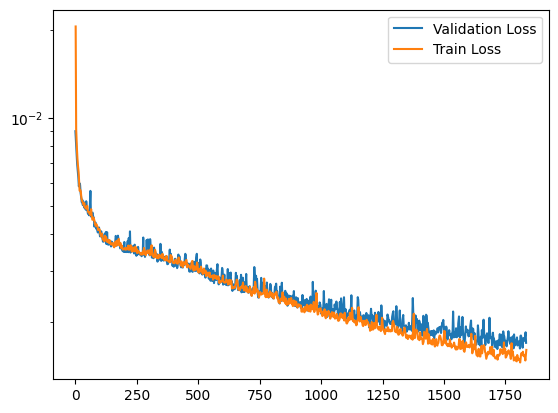

In [16]:
# ploteo del train loss y el validation loss
version_nr = 63

loss_file = pd.read_csv(f'lightning_logs/version_{version_nr}/metrics.csv')
plt.plot(loss_file['val_loss'].loc[~np.isnan(loss_file['val_loss'])] , label='Validation Loss')
plt.plot(loss_file['train_loss_epoch'].loc[~np.isnan(loss_file['train_loss_epoch'])], label='Train Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), './rnn_1_model.pth')


In [ ]:
ckpt = torch.load('./rnn_1_model.pth')
model.load_state_dict(ckpt)
model

MAE: 1.813988277473702
MSE: 5.878172280558254


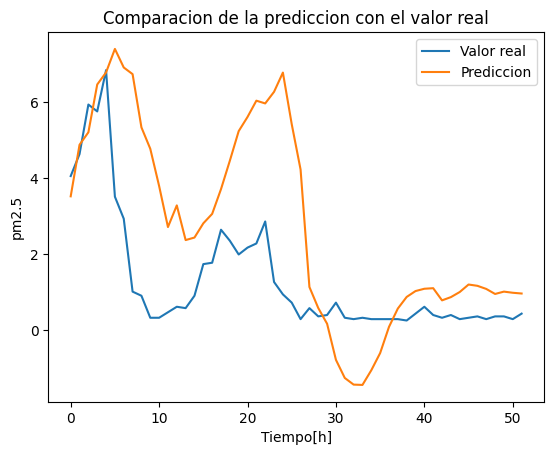

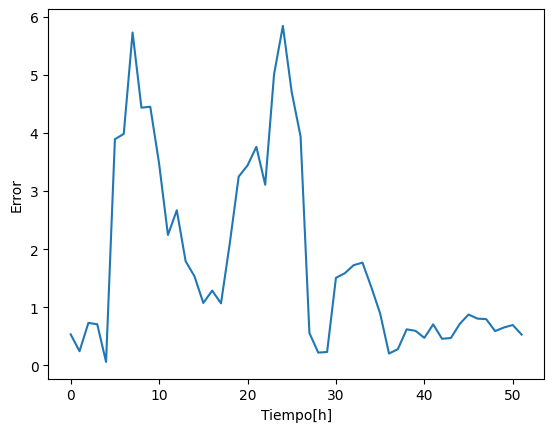

In [27]:
#model.load_from_checkpoint(f'/home/arturo/Documents/capgemini/lightning_logs/version_58/checkpoints/epoch=96-step=1455.ckpt')

model.eval()

# Predecimos los valores de test
predictions = []
truth = []
with torch.no_grad():
    for x, y in test_dataloader:
        prediction = model(x)
        predictions.append(prediction)
        truth.append(y)
        
predictions = torch.cat(predictions).cpu().numpy()
truth = torch.cat(truth).cpu().numpy()

# Desnormalizamos los valores
predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), scaled_data.shape[1]-1)), predictions), axis=1))[:, -1]
truth = scaler.inverse_transform(np.concatenate((np.zeros((len(truth), scaled_data.shape[1]-1)), truth), axis=1))[:, -1]

# Calculamos el error
error = np.abs(predictions - truth)
print(f'MAE: {np.mean(error)}')
print(f'MSE: {np.mean(error**2)}')

# Comparacion de la prediccion con el valor real
plt.plot(truth, label='Valor real')
plt.plot(predictions, label='Prediccion')
plt.title('Comparacion de la prediccion con el valor real')
plt.xlabel('Tiempo[h]')
plt.ylabel('pm2.5')
plt.legend()
plt.show()

# Grafica del error
plt.plot(error, label='Error')
plt.xlabel('Tiempo[h]')
plt.ylabel('Error')
plt.show()

# Transformer model

Cuando el data es dependiente del tiempo, siempre es recomendable intentar transformers

Es un modelo computacionalmente costoso, por lo que no es recomendable si se quiere optimizar el tiempo de computacion.

In [37]:
# Now define a transformer model to predict the PM2.5 value

class Transformer(BaseModel):
    def __init__(self, 
                 input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 n_layers: int, 
                 n_heads: int,
                 dropout: float,
                 loss_fn: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 optimizer_args: dict,
                 ):
        super().__init__(loss_fn=loss_fn, optimizer=optimizer, optimizer_args=optimizer_args)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_dim,
                nhead=n_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                activation='relu'
            ),
            num_layers=n_layers
        )
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x[:, -1, :])
        return x
    
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), **self.optimizer_args)
        return optimizer
    
    
# Definimos el modelo de Transformer que se usara para la tarea de regresion
input_dim = scaled_data.shape[1]-1
hidden_dim = 20
n_layers = 2
n_heads = 2
dropout = 0.1
output_dim = 1
loss = nn.MSELoss()
optimizer = torch.optim.Adam
optimizer_args = {'lr': 1e-3}

model = Transformer(input_dim, hidden_dim, output_dim, n_layers, n_heads, dropout, loss, optimizer, optimizer_args)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')
trainer_args = {
    'max_epochs': 400,
    'gpus': [0] if torch.cuda.is_available() else [],
    'callbacks': [early_stopping],
    'enable_progress_bar': True,    
}

trainer = pl.Trainer(**trainer_args)


/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | loss    | MSELoss            | 0     
1 | encoder | TransformerEncoder | 2.4 K 
2 | fc      | Linear             | 13    
-----------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.135, v_num=2, train_loss_step=0.0715, val_loss=0.0491]

Metric val_loss improved. New best score: 0.049


Epoch 1: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0496, v_num=2, train_loss_step=0.0308, val_loss=0.0186, train_loss_epoch=0.138]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.019


Epoch 2: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.0265, v_num=2, train_loss_step=0.024, val_loss=0.0122, train_loss_epoch=0.0457] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.012


Epoch 3: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0197, v_num=2, train_loss_step=0.0165, val_loss=0.00957, train_loss_epoch=0.0254]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.010


Epoch 4: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.0162, v_num=2, train_loss_step=0.0145, val_loss=0.00829, train_loss_epoch=0.0192]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.008


Epoch 5: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0145, v_num=2, train_loss_step=0.016, val_loss=0.00766, train_loss_epoch=0.0161] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.008


Epoch 6: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.0132, v_num=2, train_loss_step=0.0109, val_loss=0.00729, train_loss_epoch=0.0143]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 7: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0121, v_num=2, train_loss_step=0.012, val_loss=0.00709, train_loss_epoch=0.0132] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 8: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.0114, v_num=2, train_loss_step=0.011, val_loss=0.00695, train_loss_epoch=0.0122] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 9: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0107, v_num=2, train_loss_step=0.00844, val_loss=0.00687, train_loss_epoch=0.0114]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 10: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0104, v_num=2, train_loss_step=0.0122, val_loss=0.00683, train_loss_epoch=0.0107] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 11: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.01, v_num=2, train_loss_step=0.00852, val_loss=0.0068, train_loss_epoch=0.0104]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 12: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00956, v_num=2, train_loss_step=0.00912, val_loss=0.00678, train_loss_epoch=0.010]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 13: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.00936, v_num=2, train_loss_step=0.00931, val_loss=0.00678, train_loss_epoch=0.00963]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 14: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00915, v_num=2, train_loss_step=0.00979, val_loss=0.00673, train_loss_epoch=0.00938]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 15: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.009, v_num=2, train_loss_step=0.0101, val_loss=0.00671, train_loss_epoch=0.00919]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 16: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00891, v_num=2, train_loss_step=0.00927, val_loss=0.00668, train_loss_epoch=0.00891]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 17: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.00875, v_num=2, train_loss_step=0.00936, val_loss=0.00666, train_loss_epoch=0.00875]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 18: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00851, v_num=2, train_loss_step=0.00813, val_loss=0.00663, train_loss_epoch=0.00864]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 19: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.00826, v_num=2, train_loss_step=0.00667, val_loss=0.00663, train_loss_epoch=0.00847]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 20: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00819, v_num=2, train_loss_step=0.00805, val_loss=0.00659, train_loss_epoch=0.00837]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 21: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00811, v_num=2, train_loss_step=0.0076, val_loss=0.00656, train_loss_epoch=0.00822] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 22: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.00791, v_num=2, train_loss_step=0.00638, val_loss=0.00653, train_loss_epoch=0.00813]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 23: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00783, v_num=2, train_loss_step=0.00692, val_loss=0.00651, train_loss_epoch=0.00801]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Epoch 24: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.00782, v_num=2, train_loss_step=0.00853, val_loss=0.00649, train_loss_epoch=0.00797]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 25: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00784, v_num=2, train_loss_step=0.00825, val_loss=0.00646, train_loss_epoch=0.00783]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 26: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.00785, v_num=2, train_loss_step=0.00769, val_loss=0.00645, train_loss_epoch=0.00778]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 27: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0077, v_num=2, train_loss_step=0.00653, val_loss=0.00641, train_loss_epoch=0.00774] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 28: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.0076, v_num=2, train_loss_step=0.00849, val_loss=0.00639, train_loss_epoch=0.00766] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 29: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00753, v_num=2, train_loss_step=0.00659, val_loss=0.00636, train_loss_epoch=0.00758]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 31: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00755, v_num=2, train_loss_step=0.00819, val_loss=0.00634, train_loss_epoch=0.00745]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 32: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00744, v_num=2, train_loss_step=0.00752, val_loss=0.00631, train_loss_epoch=0.0075] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 33: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.00735, v_num=2, train_loss_step=0.00726, val_loss=0.0063, train_loss_epoch=0.00743] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 35: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.0073, v_num=2, train_loss_step=0.00674, val_loss=0.00629, train_loss_epoch=0.00736] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 36: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0073, v_num=2, train_loss_step=0.00764, val_loss=0.00625, train_loss_epoch=0.00727] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 37: 100%|██████████| 22/22 [00:24<00:00,  1.13s/it, loss=0.00723, v_num=2, train_loss_step=0.007, val_loss=0.00623, train_loss_epoch=0.00727]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 38: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00713, v_num=2, train_loss_step=0.00646, val_loss=0.0062, train_loss_epoch=0.00723] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 39: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00712, v_num=2, train_loss_step=0.00692, val_loss=0.00619, train_loss_epoch=0.00717]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 40: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.0071, v_num=2, train_loss_step=0.00616, val_loss=0.00617, train_loss_epoch=0.00715] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 41: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00701, v_num=2, train_loss_step=0.00641, val_loss=0.00616, train_loss_epoch=0.00713]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 42: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00702, v_num=2, train_loss_step=0.007, val_loss=0.00616, train_loss_epoch=0.00711]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 43: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00702, v_num=2, train_loss_step=0.00591, val_loss=0.00614, train_loss_epoch=0.00705]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 44: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00702, v_num=2, train_loss_step=0.00803, val_loss=0.00613, train_loss_epoch=0.00709]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 45: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.0071, v_num=2, train_loss_step=0.009, val_loss=0.00611, train_loss_epoch=0.00704]   

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 46: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00707, v_num=2, train_loss_step=0.00737, val_loss=0.00611, train_loss_epoch=0.00697]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 47: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00696, v_num=2, train_loss_step=0.00627, val_loss=0.00611, train_loss_epoch=0.00697]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 48: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00687, v_num=2, train_loss_step=0.00666, val_loss=0.00608, train_loss_epoch=0.00696]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 50: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00692, v_num=2, train_loss_step=0.0077, val_loss=0.00606, train_loss_epoch=0.00686] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 51: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00688, v_num=2, train_loss_step=0.0064, val_loss=0.00605, train_loss_epoch=0.0069] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 52: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00692, v_num=2, train_loss_step=0.00831, val_loss=0.00604, train_loss_epoch=0.00688]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 53: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00682, v_num=2, train_loss_step=0.00584, val_loss=0.00603, train_loss_epoch=0.00683]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 54: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00679, v_num=2, train_loss_step=0.00806, val_loss=0.00601, train_loss_epoch=0.00681]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 55: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00676, v_num=2, train_loss_step=0.00584, val_loss=0.006, train_loss_epoch=0.00679]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 56: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00671, v_num=2, train_loss_step=0.00658, val_loss=0.006, train_loss_epoch=0.00677]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 57: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00689, v_num=2, train_loss_step=0.00932, val_loss=0.00598, train_loss_epoch=0.00675]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 59: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.0067, v_num=2, train_loss_step=0.00715, val_loss=0.00597, train_loss_epoch=0.00674] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 61: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00656, v_num=2, train_loss_step=0.00583, val_loss=0.00595, train_loss_epoch=0.0067] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 62: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.0066, v_num=2, train_loss_step=0.0062, val_loss=0.00594, train_loss_epoch=0.00665]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 63: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00659, v_num=2, train_loss_step=0.00652, val_loss=0.00593, train_loss_epoch=0.00664]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 64: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.0066, v_num=2, train_loss_step=0.00553, val_loss=0.00593, train_loss_epoch=0.00659] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 65: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00654, v_num=2, train_loss_step=0.00681, val_loss=0.00591, train_loss_epoch=0.00662]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 67: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00656, v_num=2, train_loss_step=0.00785, val_loss=0.00589, train_loss_epoch=0.00653]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 68: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00661, v_num=2, train_loss_step=0.00675, val_loss=0.00587, train_loss_epoch=0.00656]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 72: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00643, v_num=2, train_loss_step=0.00606, val_loss=0.00584, train_loss_epoch=0.00648]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 74: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00645, v_num=2, train_loss_step=0.00584, val_loss=0.00581, train_loss_epoch=0.00646]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 75: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00646, v_num=2, train_loss_step=0.00665, val_loss=0.00581, train_loss_epoch=0.00644]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 76: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00637, v_num=2, train_loss_step=0.00555, val_loss=0.00579, train_loss_epoch=0.00645]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 78: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00635, v_num=2, train_loss_step=0.00536, val_loss=0.00577, train_loss_epoch=0.00641]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 79: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00634, v_num=2, train_loss_step=0.00654, val_loss=0.00577, train_loss_epoch=0.00639]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 80: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00635, v_num=2, train_loss_step=0.00556, val_loss=0.00574, train_loss_epoch=0.00639]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 81: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00633, v_num=2, train_loss_step=0.00678, val_loss=0.00573, train_loss_epoch=0.00635]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 82: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.0063, v_num=2, train_loss_step=0.00526, val_loss=0.00572, train_loss_epoch=0.00636] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 83: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00625, v_num=2, train_loss_step=0.00603, val_loss=0.00571, train_loss_epoch=0.00634]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 85: 100%|██████████| 22/22 [00:24<00:00,  1.12s/it, loss=0.00625, v_num=2, train_loss_step=0.00532, val_loss=0.00571, train_loss_epoch=0.00636]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 86: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.00634, v_num=2, train_loss_step=0.00761, val_loss=0.00568, train_loss_epoch=0.00627]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 87: 100%|██████████| 22/22 [00:24<00:00,  1.11s/it, loss=0.0063, v_num=2, train_loss_step=0.00591, val_loss=0.00567, train_loss_epoch=0.0063]  

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Epoch 89:  73%|███████▎  | 16/22 [00:22<00:08,  1.39s/it, loss=0.00621, v_num=2, train_loss_step=0.00686, val_loss=0.00567, train_loss_epoch=0.00624]

/home/arturo/miniconda3/envs/graphnet/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


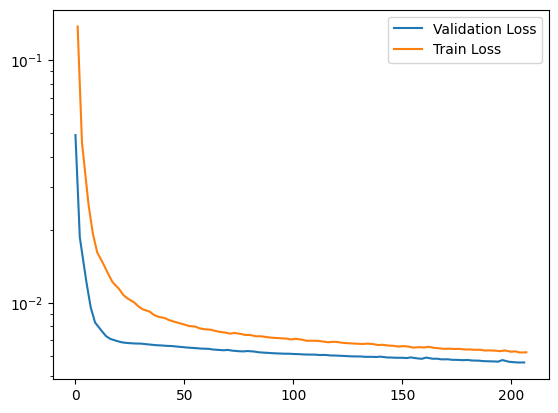

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ploteo del train loss y el validation loss
version_nr = 2

loss_file = pd.read_csv(f'lightning_logs/version_{version_nr}/metrics.csv')
plt.plot(loss_file['val_loss'].loc[~np.isnan(loss_file['val_loss'])] , label='Validation Loss')
plt.plot(loss_file['train_loss_epoch'].loc[~np.isnan(loss_file['train_loss_epoch'])], label='Train Loss')
plt.yscale('log')
plt.legend()
plt.show()

In [39]:
ckpt = torch.load('./transformer_model.pth')
model.load_state_dict(ckpt)
model

/tmp/ipykernel_176006/975044634.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('transformer_model.pth')


Transformer(
  (loss): MSELoss()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=20, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=20, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

MAE: 2.8103493616128197
MSE: 9.738864812349588


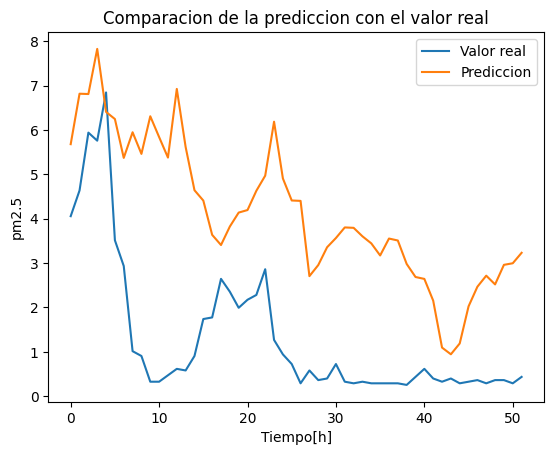

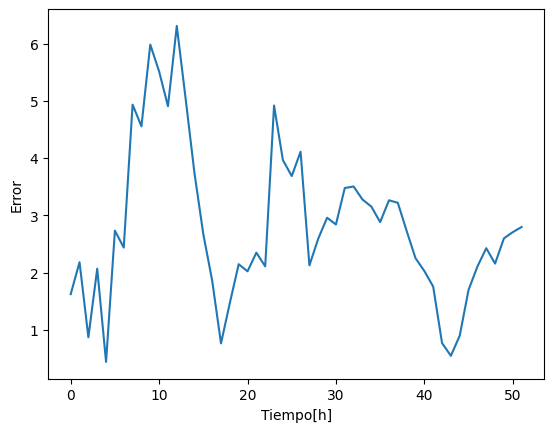

In [40]:
model.eval()

# Predecimos los valores de test
predictions = []
truth = []
with torch.no_grad():
    for x, y in test_dataloader:
        prediction = model(x)
        predictions.append(prediction)
        truth.append(y)
        
predictions = torch.cat(predictions).cpu().numpy()
truth = torch.cat(truth).cpu().numpy()

# Desnormalizamos los valores
predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), scaled_data.shape[1]-1)), predictions), axis=1))[:, -1]
truth = scaler.inverse_transform(np.concatenate((np.zeros((len(truth), scaled_data.shape[1]-1)), truth), axis=1))[:, -1]

# Calculamos el error
error = np.abs(predictions - truth)
print(f'MAE: {np.mean(error)}')
print(f'MSE: {np.mean(error**2)}')

# Comparacion de la prediccion con el valor real
plt.plot(truth, label='Valor real')
plt.plot(predictions, label='Prediccion')
plt.title('Comparacion de la prediccion con el valor real')
plt.xlabel('Tiempo[h]')
plt.ylabel('pm2.5')
plt.legend()
plt.show()

# Grafica del error
plt.plot(error, label='Error')
plt.xlabel('Tiempo[h]')
plt.ylabel('Error')
plt.show()